<a href="https://colab.research.google.com/github/juanmed/uois/blob/master/uois_sample_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Test the IOUS network on the container unloading data
# Based on https://github.com/juanmed/uois/blob/master/uois_3D_example.ipynb

In [ ]:
# Clone repository here
!git clone https://github.com/juanmed/uois
!mv uois/* ./
!rm -rf uois

In [ ]:
# install dependencies
!pip install pypng matplotlib numpy opencv-python scikit-image gdown

In [4]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # TODO: Change this if you have more than 1 GPU

import sys
import json
from time import time
import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

# My libraries. Ugly hack to import from sister directory
import src.data_augmentation as data_augmentation
import src.segmentation as segmentation
import src.evaluation as evaluation
import src.util.utilities as util_
import src.util.flowlib as flowlib

In [5]:
# data processing functions
def process_rgb(rgb_img):
    """ Process RGB image
            - random color warping
    """
    rgb_img = rgb_img.astype(np.float32)
    rgb_img = data_augmentation.standardize_image(rgb_img)
    return rgb_img

def process_depth(depth_img):
    """ Process depth channel
            TODO: CHANGE THIS
            - change from millimeters to meters
            - cast to float32 data type
            - add random noise
            - compute xyz ordered point cloud
    """

    # millimeters -> meters
    depth_img = (depth_img / 1000.).astype(np.float32)

    # add random noise to depth
    #if self.config['use_data_augmentation']:
        #depth_img = data_augmentation.add_noise_to_depth(depth_img, self.config)
        # depth_img = data_augmentation.dropout_random_ellipses(depth_img, self.config)

    # Compute xyz ordered point cloud
    params = {}
    params['img_width'] = depth_img.shape[1] 
    params['img_height'] = depth_img.shape[0]
    params['fov'] = 60
    params['near'] = 0.01
    xyz_img = util_.compute_xyz(depth_img, params)
    #if self.config['use_data_augmentation']:
    #    xyz_img = data_augmentation.add_noise_to_xyz(xyz_img, depth_img, self.config)

    return xyz_img


Depth Seeding Network Parameters

In [6]:
dsn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal

    # Mean Shift parameters (for 3D voting)
    'max_GMS_iters' : 10, 
    'epsilon' : 0.05, # Connected Components parameter
    'sigma' : 0.02, # Gaussian bandwidth parameter
    'num_seeds' : 200, # Used for MeanShift, but not BlurringMeanShift
    'subsample_factor' : 5,
    
    # Misc
    'min_pixels_thresh' : 500,
    'tau' : 15.,
    
}

Region Refinement Network parameters

In [7]:
rrn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal
    'img_H' : 224,
    'img_W' : 224,
    
    # architecture parameters
    'use_coordconv' : False,
    
}

UOIS-Net-3D Parameters

In [8]:
uois3d_config = {
    
    # Padding for RGB Refinement Network
    'padding_percentage' : 0.25,
    
    # Open/Close Morphology for IMP (Initial Mask Processing) module
    'use_open_close_morphology' : True,
    'open_close_morphology_ksize' : 9,
    
    # Largest Connected Component for IMP module
    'use_largest_connected_component' : True,
    
}

Download weights for DSN and RRN and untar

In [9]:
# The weights are in a zip file here: https://drive.google.com/uc?export=download&id=1D-eaiOgFq_mg8OwbLXorgOB5lrxvmgQd
import gdown 
url = 'https://drive.google.com/uc?id=1D-eaiOgFq_mg8OwbLXorgOB5lrxvmgQd'
outfile = 'models.tar.gz'
gdown.download(url, outfile, quiet=False)
!mkdir models/
!tar xvf models.tar.gz --directory models/

Downloading...
From: https://drive.google.com/uc?id=1D-eaiOgFq_mg8OwbLXorgOB5lrxvmgQd
To: /content/models.tar.gz
100%|██████████| 254M/254M [00:07<00:00, 35.9MB/s]


DepthSeedingNetwork_3D_TOD_checkpoint.pth
RRN_OID_checkpoint.pth
RRN_TOD_checkpoint.pth


Download sample unloader dataset

In [10]:
# sample files at https://drive.google.com/file/d/1RnnfaxXDyYjcMk2b_6sWrlgaKxP92kuP/view?usp=sharing
url = 'https://drive.google.com/uc?id=1RnnfaxXDyYjcMk2b_6sWrlgaKxP92kuP'
outfile = 'unloading_rgbd.zip'
gdown.download(url, outfile, quiet=False)
!mkdir unloading_rgbd
!unzip unloading_rgbd.zip -d unloading_rgbd/ > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1RnnfaxXDyYjcMk2b_6sWrlgaKxP92kuP
To: /content/unloading_rgbd.zip
100%|██████████| 2.39G/2.39G [00:13<00:00, 183MB/s]


In [17]:
checkpoint_dir = '/content/models/' # TODO: change this to directory of downloaded models
dsn_filename = checkpoint_dir + 'DepthSeedingNetwork_3D_TOD_checkpoint.pth'
rrn_filename = checkpoint_dir + 'RRN_TOD_checkpoint.pth'
uois3d_config['final_close_morphology'] = 'TableTop_v5' in rrn_filename
uois_net_3d = segmentation.UOISNet3D(uois3d_config, 
                                     dsn_filename,
                                     dsn_config,
                                     rrn_filename,
                                     rrn_config
                                    )

Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model


Run on example OSD/OCID images

In [ ]:
example_images_dir = os.path.abspath('.') + '/example_images/'

OSD_image_files = sorted(glob.glob(example_images_dir + '/OSD_*.npy'))
OCID_image_files = sorted(glob.glob(example_images_dir + '/OCID_*.npy'))
N = len(OSD_image_files) + len(OCID_image_files)

rgb_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
xyz_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
label_imgs = np.zeros((N, 480, 640), dtype=np.uint8)

for i, img_file in enumerate(OSD_image_files + OCID_image_files):
    d = np.load(img_file, allow_pickle=True, encoding='bytes').item()
    
    # RGB
    rgb_img = d['rgb']
    print("RGB: ",rgb_img.shape)
    rgb_imgs[i] = data_augmentation.standardize_image(rgb_img)

    # XYZ
    xyz_imgs[i] = d['xyz']
    print("Depth : ",d['xyz'].shape)

    # Label
    label_imgs[i] = d['label']
    
batch = {
    'rgb' : data_augmentation.array_to_tensor(rgb_imgs),
    'xyz' : data_augmentation.array_to_tensor(xyz_imgs),
}

In [19]:
print("Number of images: {0}".format(N))

### Compute segmentation masks ###
st_time = time()
fg_masks, center_offsets, initial_masks, seg_masks = uois_net_3d.run_on_batch(batch)
total_time = time() - st_time
print('Total time taken for Segmentation: {0} seconds'.format(round(total_time, 3)))
print('FPS: {0}'.format(round(N / total_time,3)))

# Get results in numpy
seg_masks = seg_masks.cpu().numpy()
fg_masks = fg_masks.cpu().numpy()
center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
initial_masks = initial_masks.cpu().numpy()

Number of images: 4


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4058: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4002: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Total time taken for Segmentation: 2.049 seconds
FPS: 1.952


/content/src/evaluation.py:141: RuntimeWarning: invalid value encountered in double_scalars
  F[i,j] = (2 * prec * rec) / (prec + rec)


Image 1 Metrics:
{'Objects F-measure': 0.8988788123788464, 'Objects Precision': 0.857458789421844, 'Objects Recall': 0.944503582395087, 'Boundary F-measure': 0.8222687855888444, 'Boundary Precision': 0.7426756088951642, 'Boundary Recall': 0.9209699146834306, 'obj_detected': 7, 'obj_detected_075': 6, 'obj_gt': 6, 'obj_detected_075_percentage': 1.0}
Image 2 Metrics:
{'Objects F-measure': 0.7650302414143677, 'Objects Precision': 0.7479909021986353, 'Objects Recall': 0.782863994639488, 'Boundary F-measure': 0.5959790468273993, 'Boundary Precision': 0.5851388220189375, 'Boundary Recall': 0.6072285029119562, 'obj_detected': 19, 'obj_detected_075': 9, 'obj_gt': 15, 'obj_detected_075_percentage': 0.6}
Image 3 Metrics:
{'Objects F-measure': 0.7958057611875823, 'Objects Precision': 0.7956026698076168, 'Objects Recall': 0.796008956279216, 'Boundary F-measure': 0.7622769348303222, 'Boundary Precision': 0.8548470710212546, 'Boundary Recall': 0.6877964639931005, 'obj_detected': 8, 'obj_detected_075'

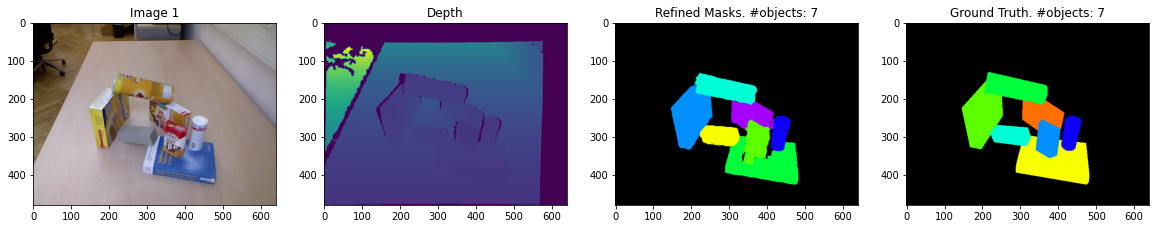

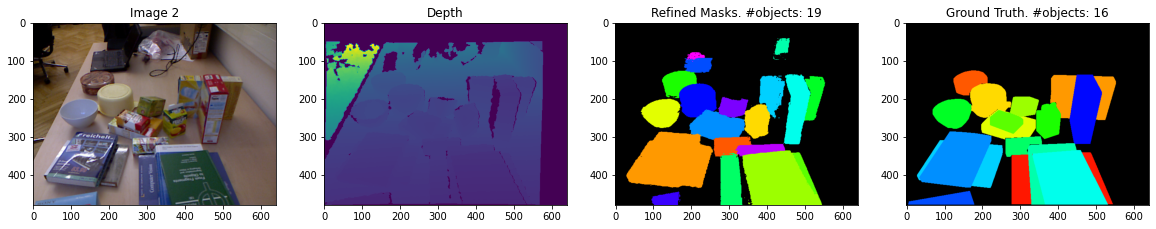

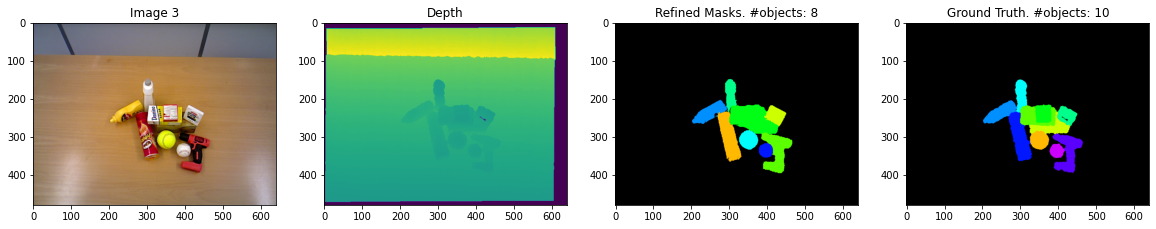

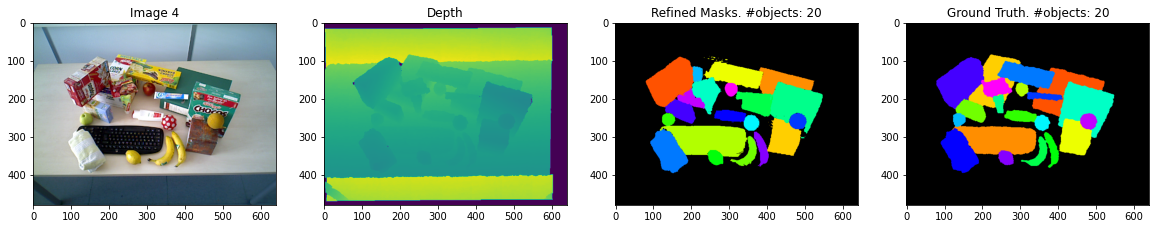

In [20]:
rgb_imgs = util_.torch_to_numpy(batch['rgb'].cpu(), is_standardized_image=True)
total_subplots = 6

fig_index = 1
for i in range(N):
    
    num_objs = max(np.unique(seg_masks[i,...]).max(), np.unique(label_imgs[i,...]).max()) + 1
    
    rgb = rgb_imgs[i].astype(np.uint8)
    depth = xyz_imgs[i,...,2]
    seg_mask_plot = util_.get_color_mask(seg_masks[i,...], nc=num_objs)
    gt_masks = util_.get_color_mask(label_imgs[i,...], nc=num_objs)
    
    images = [rgb, depth, seg_mask_plot, gt_masks]
    titles = [f'Image {i+1}', 'Depth',
              f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}",
              f"Ground Truth. #objects: {np.unique(label_imgs[i,...]).shape[0]-1}"
             ]
    util_.subplotter(images, titles, fig_num=i+1)
    
    # Run evaluation metric
    eval_metrics = evaluation.multilabel_metrics(seg_masks[i,...], label_imgs[i])
    print(f"Image {i+1} Metrics:")
    print(eval_metrics)

Process unloading data

In [24]:
color_image_folder = './unloading_rgbd/unloader_rgbd/color/'
depth_image_folder = './unloading_rgbd/unloader_rgbd/depth/'

color_images = os.listdir(color_image_folder)[:2] 


N = len(color_images)
rgb_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
xyz_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)

for i, img_file in enumerate(color_images):

    # RGB
    rgb_image = cv2.imread(os.path.join(color_image_folder,img_file), cv2.IMREAD_UNCHANGED)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    rgb_image = cv2.resize(rgb_image,(640,480))
    rgb_image = process_rgb(rgb_image)
    print("RGB: ",rgb_image.shape)
    rgb_imgs[i] = rgb_image


    # XYZ
    depth_image = cv2.imread(os.path.join(depth_image_folder,img_file), cv2.IMREAD_UNCHANGED)
    depth_image = cv2.resize(depth_image, (640,480))
    xyz_image = process_depth(depth_image)
    print("Depth: ", xyz_image.shape)
    xyz_imgs[i] = xyz_image
    
batch = {
    'rgb' : data_augmentation.array_to_tensor(rgb_imgs),
    'xyz' : data_augmentation.array_to_tensor(xyz_imgs),
}

### Compute segmentation masks ###
st_time = time()
fg_masks, center_offsets, initial_masks, seg_masks = uois_net_3d.run_on_batch(batch)
total_time = time() - st_time
print('Total time taken for Segmentation: {0} seconds'.format(round(total_time, 3)))
print('FPS: {0}'.format(round(N / total_time,3)))

# Get results in numpy
seg_masks = seg_masks.cpu().numpy()
fg_masks = fg_masks.cpu().numpy()
center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
initial_masks = initial_masks.cpu().numpy()

RGB:  (480, 640, 3)
Depth:  (480, 640, 3)
RGB:  (480, 640, 3)
Depth:  (480, 640, 3)
Total time taken for Segmentation: 0.633 seconds
FPS: 3.161


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4058: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4002: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


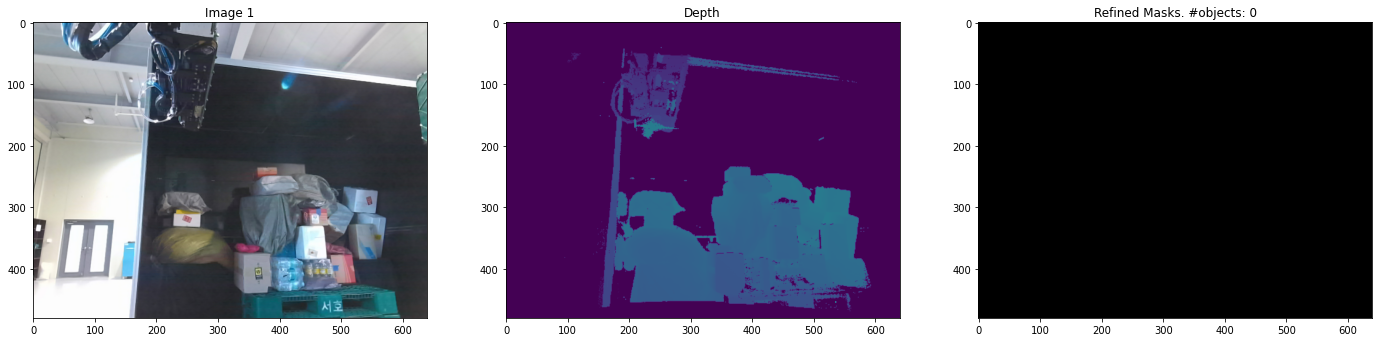

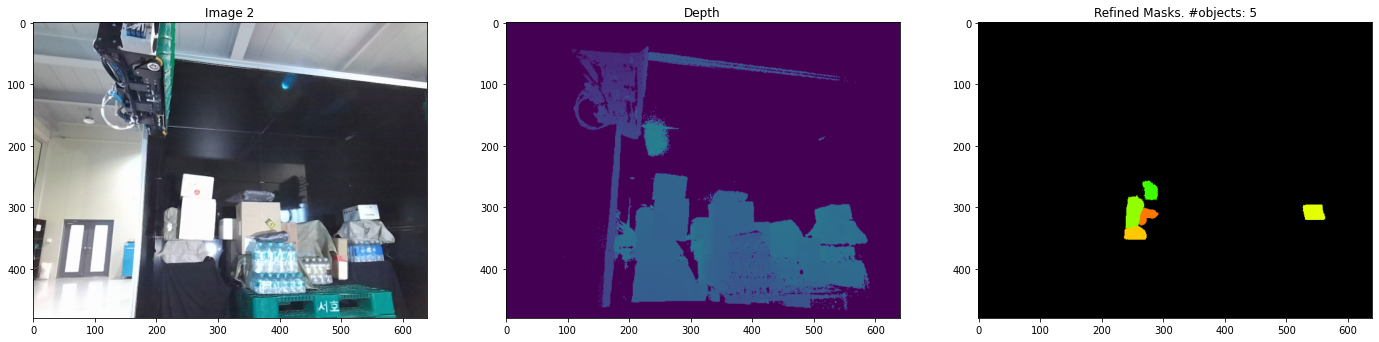

In [25]:
rgb_imgs = util_.torch_to_numpy(batch['rgb'].cpu(), is_standardized_image=True)
total_subplots = 6

fig_index = 1
for i in range(N):
    
    num_objs = max(np.unique(seg_masks[i,...]).max(), np.unique(label_imgs[i,...]).max()) + 1
    
    rgb = rgb_imgs[i].astype(np.uint8)
    depth = xyz_imgs[i,...,2]
    seg_mask_plot = util_.get_color_mask(seg_masks[i,...], nc=num_objs)
    #gt_masks = util_.get_color_mask(label_imgs[i,...], nc=num_objs)
    
    images = [rgb, depth, seg_mask_plot]#, gt_masks]
    titles = [f'Image {i+1}', 'Depth',
              f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}",
              #f"Ground Truth. #objects: {np.unique(label_imgs[i,...]).shape[0]-1}"
             ]
    util_.subplotter(images, titles, fig_num=i+1, plot_width=8)
    
    # Run evaluation metric
    #eval_metrics = evaluation.multilabel_metrics(seg_masks[i,...], label_imgs[i])
    #print(f"Image {i+1} Metrics:")
    #print(eval_metrics)